In [1]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

# Dislocation model of Okada (1985)

Based on the [Matlab function of François Beauducel (Copyright 1997-2012)](http://www.mathworks.com/matlabcentral/fileexchange/25982-okada--surface-deformation-due-to-a-finite-rectangular-source).

In [2]:
rm okada.py

In [3]:
%%writefile okada.py
import numpy as np
def chinnery(f,x,p,L,W,q,dip,nu):
    u = f(x,p,q,dip,nu) \
    - f(x,p-W,q,dip,nu) \
    - f(x-L,p,q,dip,nu) \
    + f(x-L,p-W,q,dip,nu)
    return u

Writing okada.py


In [4]:
%%writefile okada.py -a

def I4(db,eta,q,dip,nu,R):
    I = 0.0*eta
    if (np.abs(np.cos(dip))>np.finfo(1.0).eps):
        I = (1.-2*nu)*1./np.cos(dip)*(np.log(R+db)-np.sin(dip)*np.log(R+eta))
    else:
        I = -(1.-2.*nu)*q/(R+db)
    return I

Appending to okada.py


In [5]:
%%writefile okada.py -a

def I5(xi,eta,q,dip,nu,R,db):
    X = np.sqrt(xi**2+q**2)
    I = 0.0*xi
    if np.abs(np.cos(dip))>np.finfo(1.0).eps:
        I = (1-2.*nu)*2./np.cos(dip) \
                    *np.arctan( (eta*(X+q*np.cos(dip)) + X*(R+X)*np.sin(dip)  ) \
                    /(xi*(R+X)*np.cos(dip)))
        I = np.where(np.isclose(xi,0.0),0.0,I)
    else:
        I = -(1-2*nu)*xi*np.sin(dip)/(R+db)
    return I


Appending to okada.py


In [6]:
%%writefile okada.py -a

def uz_ss(xi,eta,q,dip,nu):
    R = np.sqrt(xi**2+eta**2+q**2)
    db = eta*np.sin(dip) - q*np.cos(dip)
    u = db*q/(R*(R+eta)) \
        + q*np.sin(dip)/(R+eta) \
        + I4(db,eta,q,dip,nu,R)*np.sin(dip)
    return u

Appending to okada.py


In [7]:
%%writefile okada.py -a

def uz_ds(xi,eta,q,dip,nu):
    R = np.sqrt(xi**2+eta**2+q**2)
    db = eta*np.sin(dip) - q*np.cos(dip)
    u = db*q/(R*(R+xi)) \
        - I5(xi,eta,q,dip,nu,R,db)*np.sin(dip)*np.cos(dip)
    u = np.where(q!=0.0,
                 u+np.sin(dip)*np.arctan((xi*eta)/(q*R)),
                 u)
    return u

Appending to okada.py


In [8]:
%%writefile okada.py -a

def uz_tf(xi,eta,q,dip,nu):
    R = np.sqrt(xi**2+eta**2+q**2)
    db = eta*np.sin(dip) - q *np.cos(dip)
    u = (eta*np.cos(dip) + q*np.sin(dip))*q/(R*(R+xi)) \
        + np.cos(dip)*xi*q/(R*(R+eta)) \
        - I5(xi,eta,q,dip,nu,R,db)*np.sin(dip)**2
    u = np.where( q!=0.0, 
                 u - np.cos(dip)*np.arctan(xi*eta/(q*R)),
                u)
    return u

Appending to okada.py


In [9]:
%%writefile okada.py -a

def okada(n,e,depth,strike,dip,L,W,rake,slip,U3):
    nu = 0.25
    strike = strike*np.pi/180.
    dip = dip*np.pi/180.
    rake = rake*np.pi/180.
    
    U1 = np.cos(rake)*slip
    U2 = np.sin(rake)*slip
    
    x = np.cos(strike)*n + np.sin(strike)*e;
    y = np.sin(strike)*n - np.cos(strike)*e;
    d = depth;

    x = x + 0.5*L
    y = y + 0.5*W*np.cos(dip)
    d = d + 0.5*W*np.sin(dip)
    
    p = y*np.cos(dip) + d*np.sin(dip)
    q = y*np.sin(dip) - d*np.cos(dip)    
    
    uz = -U1/(2.*np.pi) * chinnery(uz_ss,x,p,L,W,q,dip,nu) \
        - U2/(2.*np.pi) * chinnery(uz_ds,x,p,L,W,q,dip,nu) \
        + U3/(2.*np.pi) * chinnery(uz_tf,x,p,L,W,q,dip,nu)    
    return uz

Appending to okada.py


# Examples

## A basic example (from the original code)

In [10]:
from okada import okada

In [11]:
e,n = np.meshgrid(np.linspace(-10,10,100),np.linspace(-10,10,100))

In [12]:
depth = 2.
strike = 30.
dip = 70.
L = 5.
W = 3.
rake = -45.
slip = 1.0
U3 = 1.0

uz1  = okada(n,e,depth,strike,dip,L,W,rake,slip,U3)

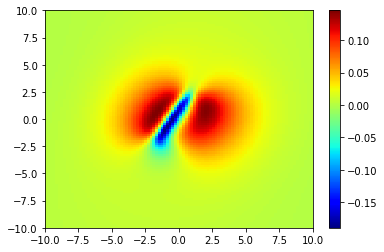

In [13]:
plt.pcolormesh(e,n,uz1,cmap=plt.cm.jet)
plt.colorbar()

# Okada (1985) reference solution

## Case 2

$ x = 2$;
$ y = 3$;
$ d = 4$;
$ \delta = 70$;
$ L = 3$
$ W = 2$

And I only care about $u_z$

In [17]:
L = 3
W = 2
x = 2
y = 3
d = 4
dip = 70
strike = 90

In [18]:
depth = d-np.sin(np.deg2rad(dip))
e = x - L/2
n = y - np.cos(np.deg2rad(dip))

If strike-slip fault (rake=0) then $u_z$  should be -2.74E-3

In [19]:
okada(n=n, e=e, depth=depth, strike=strike, dip=dip, L=L, W=W, rake=0, slip=1, U3=0)

-0.0027474058276388226

If dip-slip fault (rake=90) then $u_z$  should be -3.564E-2

In [20]:
okada(n=n, e=e, depth=depth, strike=strike, dip=dip, L=L, W=W, rake=90, slip=1, U3=0)

-0.035638557673268588

If tensile-slip fault (rake=0, slip = 0, U3=1) then $u_z$  should be +3.214E-3

In [21]:
okada(n=n, e=e, depth=depth, strike=strike, dip=dip, L=L, W=W, rake=0, slip=0, U3=1)

0.0032141931142209918

## Case 3

$ x = 0$;
$ y = 0$;
$ d = 4$;
$ \delta = 90$;
$ L = 3$
$ W = 2$


In [22]:
L = 3
W = 2
x = 0
y = 0
d = 4
dip = 90
rake = 0
strike = 90

In [23]:
depth = d-np.sin(np.deg2rad(dip))
e = x - L/2
n = y - np.cos(np.deg2rad(dip))

If strike-slip fault (rake=0) then $u_z$  should be 0

In [24]:
okada(n=n, e=e, depth=depth, strike=strike, dip=dip, L=L, W=W, rake=rake, slip=1, U3=0)

-3.503278240701084e-18

If dip-slip fault (rake=90) then $u_z$  should be 0

In [25]:
okada(n=n, e=e, depth=depth, strike=strike, dip=dip, L=L, W=W, rake=90, slip=1, U3=0)

3.5339496460705743e-17

If tensile-slip fault (rake=0, slip = 0, U3=1) then $u_z$  should be -1.606E-2

In [26]:
okada(n=n, e=e, depth=depth, strike=strike, dip=dip, L=L, W=W, rake=0, slip=0, U3=1)

-0.016062746464282643

## Case 4

$ x = 0$;
$ y = 0$;
$ d = 6$;
$ \delta = -90$;
$ L = 3$
$ W = 2$

for strike-slip it is the same as

$\delta = 90$
 and $rake = 180$

but does not generate singularities $ \tilde d+R=0$ in $I_4$

In [27]:
L = 3
W = 2
x = 0
y = 0
d = 6
dip = 90
rake = 180
strike = 90

In [29]:
depth = d-np.sin(np.deg2rad(dip))
e = x - L/2
n = y - np.cos(np.deg2rad(dip))

If strike-slip fault (rake=0) then $u_z$  should be 0

In [33]:
okada(n=n, e=e, depth=depth, strike=strike, dip=dip, L=L, W=W, rake=180, slip=1, U3=0)

1.2183678576695838e-18

If dip-slip fault (rake=90) then $u_z$  should be 0

In [31]:
okada(n=n, e=e, depth=depth, strike=strike, dip=dip, L=L, W=W, rake=90, slip=1, U3=0)

3.5339496460705743e-17

If tensile-slip fault (rake=0, slip = 0, U3=1) then $u_z$  should be -7.740E-3

In [32]:
okada(n=n, e=e, depth=depth, strike=strike, dip=dip, L=L, W=W, rake=0, slip=0, U3=1)

-0.0077401310862502907

# Finite-fault model example: USGS Chile 2010

In [ ]:
import utm

In [ ]:
def multi_okada(e,n,xy,depth,strike,dip,L,W,rake,slip):
    nfault = data.shape[0]
    uz = np.zeros_like(e)
    for i in range(nfault):
        ce = xy[i,0]
        cn = xy[i,1]
        U3 = 0.0
        uz  += okada(n-cn,e-ce,depth[i],strike[i],dip[i],L[i],W[i],rake[i],slip[i],U3)
    return uz

In [ ]:
data = np.loadtxt('static_out.txt',skiprows=10)
xy = np.array([utm.from_latlon(data[i,0],data[i,1],force_zone_number=18)[0:2] for i in range(data.shape[0])])

In [ ]:
e = np.linspace(xy[:,0].min(),xy[:,0].max(),100*2)
n = np.linspace(xy[:,1].min(),xy[:,1].max(),100*2)
e,n = np.meshgrid(e,n)

In [ ]:
depth = data[:,2]*1000.
strike = data[:,5]
dip = data[:,6]
L = 30000.*np.ones((data.shape[0],))
W = 20000.*np.ones((data.shape[0],))
rake =   data[:,4]
slip =  data[:,3]/100.

In [ ]:
uz = multi_okada(e,n,xy,depth,strike,dip,L,W,rake,slip)

In [ ]:
plt.pcolormesh(e,n,uz,vmin=-2,vmax=4.1,shading='gouroud',cmap=plt.cm.jet)
plt.axis('equal')

In [ ]:
plt.subplot(121)
plt.pcolormesh(e,n,uz,vmin=-2,vmax=4.1,cmap=plt.cm.jet)
plt.colorbar()
plt.axis('equal');
plt.axis('off')

plt.subplot(122)
plt.scatter(xy[:,0],xy[:,1],c=data[:,3],cmap=plt.cm.jet)
plt.colorbar()
plt.axis('equal');
plt.axis('off')

plt.tight_layout()
plt.savefig('asdf.png')

## With topography

In [ ]:
from scipy.io import loadmat
h = loadmat('../data/MorenoCS_h')

In [ ]:
xb = h['xh'][0,0][0,:]
yb = h['yh'][0,0][0,:]
zb = h['zh'][0,0]

In [ ]:
plt.figure(figsize=(9,9))
plt.pcolormesh(xb,yb,zb,cmap=plt.cm.Greens)
plt.contour(xb,yb,zb,[0.0])
plt.pcolormesh(e,n,uz,vmin=-2,vmax=4.1)
plt.colorbar()
plt.axis('equal')
plt.axis('off')
plt.tight_layout()

In [ ]:
plt.pcolormesh(zb)
plt.colorbar()

# Plane fault

Data from

    XXV CONGRESO LATINOAMERICANO DE HIDRÁULICA
    SAN JOSÉ, COSTA RICA, 9 AL 12 DE SETIEMBRE DE 2012
    ANÁLISIS ESPECTRAL APLICADO A LOS RESULTADOS DE UN
    MODELO NUMÉRICO DEL TSUNAMI DEL 27 DE FEBRERO DE 2010
    Luis Burgos G. y Patricio Catalán M.

In [ ]:
ll = utm.from_latlon(-39.,-75.,force_zone_number=18)
ur = utm.from_latlon(-32.,-71.,force_zone_number=18)

In [ ]:
ll,ur

In [ ]:
utm.from_latlon?

In [ ]:
c = utm.from_latlon(-35.95,-73.15)
# c = [0.5*(ll[0]+ur[0]),0.5*(ll[1]+ur[1])]
e = np.linspace(ll[0],ur[0],100)
n = np.linspace(ll[1],ur[1],100)
e,n = np.meshgrid(e,n)

In [ ]:
depth = 30100
strike = 18.
dip = 18.
L = 450000.
W = 150000.
rake =   112.
slip =  6.06

In [ ]:
c

In [ ]:
U3 = 1.0

uz1  = okada(n-c[1],e-c[0],depth,strike,dip,L,W,rake,slip,U3)

In [ ]:
plt.pcolormesh(e,n,uz1,vmin=-2,vmax=4.5)
plt.colorbar()
plt.contour(xb,yb,zb,[0.0])

plt.scatter(c[0],c[1])
plt.xlim(ll[0],ur[0])
plt.ylim(ll[1],ur[1])
# plt.axis('equal')

